In the following, we experiment with aDM-identifiability of the true map, where $\operatorname{aDM}=0$, upon composition with a measure-preserving automorphism.

In [1]:
from jax import numpy as np
from jax import random

import numpy as onp

In [2]:
rng, flow_rng = random.split(random.PRNGKey(0))
key = rng

0. Generate and plot sources

In [3]:
# N:=Number of samples
N = 1000
# D:=Number of dimensions
D = 2

# Generate the samples
S = random.uniform(key, shape=(N, D), minval=0.0, maxval=1.0)

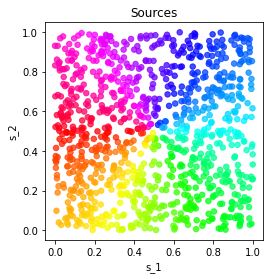

In [4]:
from plotting import cart2pol, scatterplot_variables

_, colors = cart2pol( S[:,0]-0.5, S[:,1]-0.5)

# Plot the sources
scatterplot_variables(S, 'Sources', colors=colors, savefig=False)

1. Generate maps with $\operatorname{aDM}=0$

**Conformal maps in $D=2$**: Uncomment the two cells below to use a mixing based on conformal maps in 2d.

In [5]:
# from mixing_functions import build_conformal_map

In [6]:
# # nonlinearity = lambda x : x**3
# # nonlinearity = lambda x : np.sqrt(2/x)
# # nonlinearity = lambda x : np.tanh(1.5*x)
# # nonlinearity = lambda x : np.log(x)
# # nonlinearity = lambda x : np.sinh(x)
# nonlinearity = lambda x : np.exp(1.1*x)

# mixing, mixing_gridplot = build_conformal_map(nonlinearity)

**Möbius transformations in $D \geq 2$**: Uncomment the two cells below to use a mixing based on Möbius transformations, see link below:

https://en.wikipedia.org/wiki/M%C3%B6bius_transformation#Higher_dimensions

In [7]:
from mixing_functions import build_moebius_transform

In [8]:
# Generate a random orthogonal matrix
from scipy.stats import ortho_group # Requires version 0.18 of scipy

A = ortho_group.rvs(dim=D)

# Scalar
alpha = 2.0
# Two vectors with data dimensionality
a = 2.0 * np.ones(D) # a vector in \RR^D
b = 3.0 * np.ones(D) # a vector in \RR^D

from jax import vmap
mixing_moebius, _ = build_moebius_transform(alpha, A, a, b, epsilon=2)
mixing_batched = vmap(mixing_moebius)

In [9]:
X = mixing_batched(S)
X -= np.mean(X, axis=0)

Plot observations

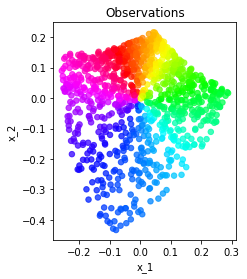

In [10]:
scatterplot_variables(X, 'Observations', colors=colors, savefig=False)#True, fname="observations_flow")

2. Compose measure-preserving automorphism and Möbius transformation

In [11]:
from mixing_functions import build_automorphism

The measure preserving automorphism is indexed by a single parameter, the angle of the rotation matrix $\theta$.

In [12]:
# Build a rotation matrix

theta = np.radians(75)
c, s = np.cos(theta), np.sin(theta)
R = np.array([[c, -s], [s, c]])

We build both the measure preserving automorphism and its inverse.

In [13]:
measure_preserving, measure_preserving_inv = build_automorphism(R)

In [14]:
measure_preserving_batched = vmap(measure_preserving)

We transform the sources with the direct function, and plot them.

In [15]:
Y = measure_preserving_batched(S)

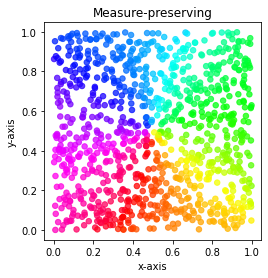

In [16]:
scatterplot_variables(Y, 'Measure-preserving', colors=colors, savefig=False)#True, fname="observations_flow")

The effect is somewhat similar to a rotation.

We now need to compose from the right the **inverse** of the mpa with the previously defined mixing. Why the inverse? Note that we have to get to the same observations,

$x$ = `mixing_moebius`($s$) 

$x$ = `composed_transformation`(`measure_preserving`($s$)) = `composed_transformation`($y$) 

In [17]:
def composed_transformation(x):
    y = measure_preserving_inv(x)
    return mixing_moebius(y)

In [18]:
composed_mixing_batched = vmap(composed_transformation)

In [19]:
X_ = composed_mixing_batched(Y)
X_ -= np.mean(X_, axis=0)

Check that we get the same observations when applying our composed mixing to Y.

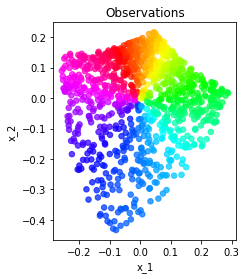

In [20]:
scatterplot_variables(X_, 'Observations', colors=colors, savefig=False)#True, fname="observations_flow")

3. Compare aDM of the true and learned solution

In [21]:
from metrics import aDM

In [22]:
from jax import jacfwd

In [23]:
# Compute the batched Jacobian
Jmixing_moebius = jacfwd(mixing_moebius)
Jmixing_moebius_batched = vmap(Jmixing_moebius)
# Compute aDM true
true_aDM = aDM(Jmixing_moebius_batched, S)

In [24]:
print(true_aDM)

-1.2665987e-09


In [25]:
Jcomposed = jacfwd(composed_transformation)
Jcomposed_batched = vmap(Jcomposed)
# Compute aDM true
composed_aDM = aDM(Jcomposed_batched, Y)

In [26]:
print(composed_aDM)

0.17388225


Higher!

In [27]:
angles = np.linspace(0, 360, num=720)
aDMs = onp.copy(angles)

for i, angle in enumerate(angles):
    # Build a rotation matrix
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c, -s], [s, c]])

    # Build measure pres. automorphism
    measure_preserving, measure_preserving_inv = build_automorphism(R)

#     Map the sources through **direct** mpa
    measure_preserving_batched = vmap(measure_preserving)
    Y = measure_preserving_batched(S)

    # Compose **its inverse** it with the mixing
    def composed_transformation(y):
        s = measure_preserving_inv(y)
        return mixing_moebius(s)

    # Compute the Jacobian
    Jcomposed = jacfwd(composed_transformation)
    Jcomposed_batched = vmap(Jcomposed)
    # Compute aDM true
    composed_aDM = aDM(Jcomposed_batched, Y)
    aDMs[i] = composed_aDM

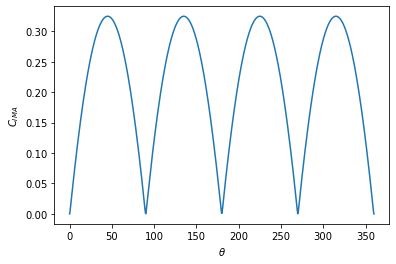

In [28]:
import matplotlib.pyplot as plt
plt.plot(angles, aDMs)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$C_{IMA}$')
plt.show()